## Хакатон по распознаванию хот-догов. 
По мотивам крутейшего стартапа из сериала "кремниевая долина"!

https://www.youtube.com/watch?v=pqTntG1RXSY


Ваша задача: сделать революционный классификатор, который сразил большинство инвесторов и гиков из кремниевой долины не один раз!

Точнее, вам необходимо предсказать, есть на изображении хот-дог или нет. В файл с решением необходимо записать вероятность того, что на изображении **есть хот-дог**.

Качество модели будет измеряться с помощью метрики AUC-ROC, публичный лидерборд (рейтинговая таблица соревнования на платформе kaggle) будет строиться по 50% наблюдений. 

Чуть подробнее про публичный и приватный лидерборд: вам дана тестовая выборка, для которой неизвестна целевая переменная. Вы обучаете модель, предсказываете для тестовой выборки, формируете из предсказаний csv-файл, и загружаете его на платформу kaggle. Видите значение метрики AUC-ROC. Это значение называется метрикой на публичном лидерборде, и считается оно не по всем данным, а лишь по 50% от тестовой выборки. Когда соревнование заканчивается, AUC-ROC пересчитывается уже для 100% тестовой выборки, и это уже называется приватный лидерборд, он же - финальный.

Такой подход является классическим для большей части соревнований по анализу данных, и основан он на том, что если не делать такого разделения, то будет происходить неявное переобучение модели под тестовую выборку. 

На этом вводная часть заканчивается, и мы искренне желаем вам удачи :) <br>
Сможете ли вы повторить успех Jian Yuang'a? Мы в вас верим!

<hr>

Разархивируем файлы с данными и импортируем необходимые библиотеки

In [0]:
!unzip -q -o test.zip
!unzip -q -o train.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
from google.colab import drive
drive.mount("/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /drive


In [0]:
import zipfile

zip_ref = zipfile.ZipFile("/drive/My Drive/Colab Notebooks/train.zip", 'r')
zip_ref.extractall("./")
zip_ref.close()

zip_ref = zipfile.ZipFile("/drive/My Drive/Colab Notebooks/test.zip", 'r')
zip_ref.extractall("./")
zip_ref.close()

In [0]:
import os

import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from matplotlib.image import imread
import matplotlib.pyplot as plt
%matplotlib inline

##########################################

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical


In [0]:
font = {
    'family': 'serif',
    'color':  'darkred',
    'weight': 'bold',
    'size': 22,
}

Загрузим данные для обучения и лидерборда

In [0]:
SEED = 257

TRAIN_DIR = 'train/'
TEST_DIR = 'test/'

In [0]:
categories = ['hot dog', 'not hot dog']

In [0]:
X, y = [], []

for category in categories:
    category_dir = os.path.join(TRAIN_DIR, category)
    for image_path in os.listdir(category_dir):
        X.append(imread(os.path.join(category_dir, image_path)))
        y.append(category)

Сколько у нас файлов есть для обучения?

In [8]:
len(X), len(y)

(10049, 10049)

Имеем картинки 100х100 пикселей в трех измерения (RGB - red, green, blue)

In [9]:
X[0].shape

(100, 100, 3)

Посмотрим немного на примеры из обучающей выборки (лучше делать это сытым)

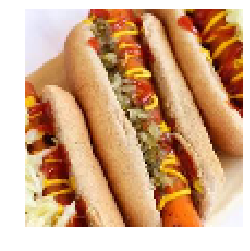

In [10]:
plt.axis("off");
plt.imshow(X[0]);

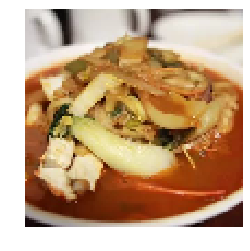

In [11]:
plt.axis("off");
plt.imshow(X[-1]);

Разделим данные на обучающую и тестовую выборки

In [0]:
y = [1 if x == 'hot dog' else 0 for x in y]

In [13]:
y_encoded = to_categorical(y)
print(y_encoded)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [0]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y_encoded), test_size=0.25, random_state=SEED)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7536, 100, 100, 3), (2513, 100, 100, 3), (7536, 2), (2513, 2))

Построим очень простой классификатор, который будем считать за baseline. Преобразуем наши изображения следующим образом: для каждой картинки посчитаем среднее значение по каждому каналу (red, green, blue). Теперь в качестве признаков, описывающих объект, будет использовать просто три средних, вместо всего набора пикселей. 

In [0]:
X_train_simplify = []
X_test_simplify = []

X_train_s = []
X_test_s = []

In [0]:
for x in X_train:
    X_train_simplify.append(np.mean(x.reshape(100*100, 3), axis=0))
    X_train_s.append(np.mean(x.reshape(100, 100, 3), axis=0))

for x in X_test:
    X_test_simplify.append(np.mean(x.reshape(100*100, 3), axis=0))
    X_test_s.append(np.mean(x.reshape(100, 100, 3), axis=0))

In [0]:
X_train_simplify = np.array(X_train_simplify) 
X_test_simplify = np.array(X_test_simplify)

X_train_s = np.array(X_train_s) 
X_test_s = np.array(X_test_s)

In [19]:
y_test

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

Получили обучающую выборку, в которой каждый объект представлен всего 3-мя признаками. 

In [20]:
X_train_simplify.shape, X_test_simplify.shape

((7536, 3), (2513, 3))

In [21]:
X_train_s.shape, X_test_s.shape

((7536, 100, 3), (2513, 100, 3))

Обучим модель и посмотрим на целевую метрику (ROC AUC)

In [22]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=SEED)
random_forest.fit(X_train_simplify, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=257, verbose=0, warm_start=False)

In [27]:
roc_auc_score(y_test, random_forest.predict_proba(X_test_simplify)[:,1])

TypeError: ignored

In [0]:
#X_test

In [0]:

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (100,100,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

In [0]:
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc
optimizer = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', auc])

#model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[auc])

In [49]:
model.fit(X_train, y_train, 
          batch_size=512,
          epochs=10,
          validation_data=(X_test, y_test))

Train on 7536 samples, validate on 2513 samples
Epoch 1/10
7536/7536 [==============================] - 15s 2ms/sample - loss: 0.9853 - acc: 0.5299 - auc: 0.5186 - val_loss: 0.6912 - val_acc: 0.5404 - val_auc: 0.5334
Epoch 2/10
7536/7536 [==============================] - 15s 2ms/sample - loss: 0.7533 - acc: 0.5715 - auc: 0.5483 - val_loss: 0.6703 - val_acc: 0.8440 - val_auc: 0.5685
Epoch 3/10
7536/7536 [==============================] - 15s 2ms/sample - loss: 0.6938 - acc: 0.6070 - auc: 0.5840 - val_loss: 0.6063 - val_acc: 0.8794 - val_auc: 0.6009
Epoch 4/10
7536/7536 [==============================] - 15s 2ms/sample - loss: 0.6242 - acc: 0.6559 - auc: 0.6178 - val_loss: 0.5761 - val_acc: 0.8794 - val_auc: 0.6340
Epoch 5/10
7536/7536 [==============================] - 15s 2ms/sample - loss: 0.5728 - acc: 0.7142 - auc: 0.6502 - val_loss: 0.5375 - val_acc: 0.8794 - val_auc: 0.6659
Epoch 6/10
7536/7536 [==============================] - 15s 2ms/sample - loss: 0.5380 - acc: 0.7602 - auc: 

In [51]:
model.fit(X_train, y_train, 
          batch_size=512,
          epochs=5,
          validation_data=(X_test, y_test))

Train on 7536 samples, validate on 2513 samples
Epoch 1/5
7536/7536 [==============================] - 15s 2ms/sample - loss: 0.3768 - acc: 0.8868 - auc: 0.7969 - val_loss: 0.4484 - val_acc: 0.8794 - val_auc: 0.8050
Epoch 2/5
7536/7536 [==============================] - 14s 2ms/sample - loss: 0.3515 - acc: 0.9002 - auc: 0.8130 - val_loss: 0.4213 - val_acc: 0.8794 - val_auc: 0.8202
Epoch 3/5
7536/7536 [==============================] - 15s 2ms/sample - loss: 0.3223 - acc: 0.9091 - auc: 0.8273 - val_loss: 0.4002 - val_acc: 0.8794 - val_auc: 0.8335
Epoch 4/5
7536/7536 [==============================] - 14s 2ms/sample - loss: 0.2995 - acc: 0.9228 - auc: 0.8401 - val_loss: 0.3803 - val_acc: 0.8794 - val_auc: 0.8455
Epoch 5/5
7536/7536 [==============================] - 14s 2ms/sample - loss: 0.2768 - acc: 0.9287 - auc: 0.8511 - val_loss: 0.3673 - val_acc: 0.8794 - val_auc: 0.8559


In [55]:
model.fit(X_train, y_train, 
          batch_size=512,
          epochs=3,
          validation_data=(X_test, y_test))

Train on 7536 samples, validate on 2513 samples
Epoch 1/3
7536/7536 [==============================] - 15s 2ms/sample - loss: 0.1958 - acc: 0.9541 - auc: 0.8851 - val_loss: 0.3408 - val_acc: 0.8794 - val_auc: 0.8881
Epoch 2/3
7536/7536 [==============================] - 15s 2ms/sample - loss: 0.1848 - acc: 0.9562 - auc: 0.8915 - val_loss: 0.3401 - val_acc: 0.8794 - val_auc: 0.8941
Epoch 3/3
7536/7536 [==============================] - 14s 2ms/sample - loss: 0.1694 - acc: 0.9611 - auc: 0.8972 - val_loss: 0.3321 - val_acc: 0.8794 - val_auc: 0.8997


In [60]:
model.fit(X_train, y_train, 
          batch_size=512,
          epochs=6,
          validation_data=(X_test, y_test))

Train on 7536 samples, validate on 2513 samples
Epoch 1/6
7536/7536 [==============================] - 15s 2ms/sample - loss: 0.1522 - acc: 0.9670 - auc: 0.9025 - val_loss: 0.3417 - val_acc: 0.8794 - val_auc: 0.9048
Epoch 2/6
7536/7536 [==============================] - 14s 2ms/sample - loss: 0.1419 - acc: 0.9659 - auc: 0.9073 - val_loss: 0.3171 - val_acc: 0.8814 - val_auc: 0.9095
Epoch 3/6
7536/7536 [==============================] - 14s 2ms/sample - loss: 0.1281 - acc: 0.9724 - auc: 0.9119 - val_loss: 0.3788 - val_acc: 0.8794 - val_auc: 0.9136
Epoch 4/6
7536/7536 [==============================] - 15s 2ms/sample - loss: 0.1131 - acc: 0.9765 - auc: 0.9157 - val_loss: 0.3526 - val_acc: 0.8798 - val_auc: 0.9173
Epoch 5/6
7536/7536 [==============================] - 15s 2ms/sample - loss: 0.1095 - acc: 0.9747 - auc: 0.9193 - val_loss: 0.3564 - val_acc: 0.8810 - val_auc: 0.9208
Epoch 6/6
7536/7536 [==============================] - 15s 2ms/sample - loss: 0.0942 - acc: 0.9802 - auc: 0.9226

In [61]:
model.fit(X_train, y_train, 
          batch_size=512,
          epochs=6,
          validation_data=(X_test, y_test))

Train on 7536 samples, validate on 2513 samples
Epoch 1/6
7536/7536 [==============================] - 15s 2ms/sample - loss: 0.0886 - acc: 0.9806 - auc: 0.9258 - val_loss: 0.3738 - val_acc: 0.8826 - val_auc: 0.9271
Epoch 2/6
7536/7536 [==============================] - 15s 2ms/sample - loss: 0.0839 - acc: 0.9797 - auc: 0.9286 - val_loss: 0.4223 - val_acc: 0.8802 - val_auc: 0.9297
Epoch 3/6
7536/7536 [==============================] - 15s 2ms/sample - loss: 0.0755 - acc: 0.9837 - auc: 0.9311 - val_loss: 0.3092 - val_acc: 0.8898 - val_auc: 0.9323
Epoch 4/6
7536/7536 [==============================] - 15s 2ms/sample - loss: 0.0690 - acc: 0.9849 - auc: 0.9338 - val_loss: 0.3642 - val_acc: 0.8862 - val_auc: 0.9348
Epoch 5/6
7536/7536 [==============================] - 15s 2ms/sample - loss: 0.0654 - acc: 0.9847 - auc: 0.9361 - val_loss: 0.3372 - val_acc: 0.8854 - val_auc: 0.9371
Epoch 6/6
7536/7536 [==============================] - 15s 2ms/sample - loss: 0.0580 - acc: 0.9867 - auc: 0.9384

In [0]:
roc_auc_score(y_test, model.predict_classes(X_test)[:,1])

IndexError: too many indices for array

### Сформируем файл с предсказаниями

In [0]:
leaderboard_X = []
leaderboard_filenames = []

In [0]:
for image_path in os.listdir(TEST_DIR):
    leaderboard_X.append(imread(os.path.join(TEST_DIR, image_path)))
    leaderboard_filenames.append(image_path)

Глянем, что тут у нас вкусного в выборке для leaderboard?

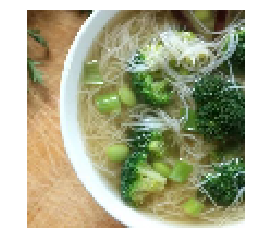

In [0]:
plt.axis("off");
plt.imshow(leaderboard_X[0]);

In [0]:
print(leaderboard_X[0].shape, leaderboard_filenames[0])

(100, 100, 3) 0003a33387289b715622ad0c3e2b5e8ba075269ad61c80b76185e40b7e33bf1c.png


In [0]:
leadeboard_predictions = []
#print(leaderboard_X[0])

for x in leaderboard_X:
    leadeboard_predictions.append(
        random_forest.predict_proba([np.mean(x.reshape(100*100, 3), axis=0)])[:,1][0]
    )


In [0]:
leadeboard_predictions = []

for x in np.array(leaderboard_X):
    #print(np.array([x]))
    leadeboard_predictions.append(
        model.predict_proba(np.array([x]))[:,1][0]
    )

Посмотрим, как бы работало наше приложение :)<br>
Вы можете менять значение переменной ```idx```, и смотреть, что предсказывает модель на различных изображениях.

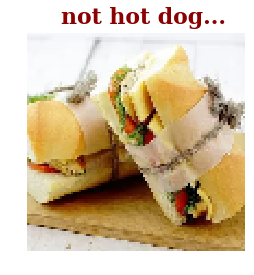

In [0]:
idx = 50

plt.axis("off");
if leadeboard_predictions[idx] > 0.5:
    plt.text(20, -5, 'HOT DOG!!!', fontdict=font)
else:
    plt.text(15, -5,'not hot dog...', fontdict=font)
plt.imshow(leaderboard_X[idx]);

Формируем DataFrame, содержащий наше решение

In [0]:
submission = pd.DataFrame(
    {
        'image_id': leaderboard_filenames, 
        'image_hot_dog_probability': leadeboard_predictions
    }
)

In [64]:
submission.head()

,image_hot_dog_probability,image_id
0,0.016181,1b53b03c84904698d93180cbea9b187217b23029b74c47...
1,0.006448,6c2247cca7d5436383fd0fc13fb5aca8979139bfe87ca2...
2,0.016635,1e59ec5fdd6441d073259526200da401a104fb0a9fcfad...
3,0.014201,6d6463d5ae2a220d499023d2defbe63abdf0b3496e0860...
4,0.005753,2ee5627f19acb1da7e476ada935a1e9d3a3ebf27ed6c93...


Сохраним результат в submit.csv, который нужно отправить на kaggle. Сделайте это!

Ссылку на соревнование вы можете получить у своего куратора. 

In [0]:
submission.to_csv('submit.csv', index=False)

### Идеи для развития и улучшения модели!

1. Попробуйте в качестве модели сверточную нейронную сеть: экспериментируйте с архитектурами, алгоритмами оптимизации. 
2. Сделайте аугментацию (data augmentation) обучающей выборки. 
3. Найдите больше данных и используйте их для обучения модели! Только не забывайте о том, что распределение классов hot-dog \ not hot-dog должно оставаться на прежнем уровне. 
4. Используйте технику transfer learning: ее идея заключается в дообучении на ваших данных модели, хорошо работающей на каком-либо датасете (в изображениях это обычно ImageNet). Стоит обратить внимание на модели семейства ResNet. 
5. Посмотрите в сторону блендинга (blending) - это способ, позволяющий объединить предсказания нескольких моделей, что в результате может вам дать более устойчивый классификатор